# File 1

### Import libs

In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, BayesianRidge, Lars, Perceptron
from sklearn import svm

# Tested this libs below
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.svm import SVR
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

### Import data and filter

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")
df = df[df.location == "World"] # take just data grouped already (world)
df.drop(['iso_code', 'continent', 'location'], axis=1, inplace=True)
df = df.loc[:, ['date','new_cases']] #Just need these two columns
df = df.reset_index(drop=True) 
df

,date,new_cases,new_deaths
0,2019-12-31,27.0,0.0
1,2020-01-01,0.0,0.0
2,2020-01-02,0.0,0.0
3,2020-01-03,17.0,0.0
4,2020-01-04,0.0,0.0
...,...,...,...
314,2020-11-09,518194.0,6135.0
315,2020-11-10,554588.0,8172.0
316,2020-11-11,551098.0,9970.0
317,2020-11-12,583521.0,10208.0


### Verify if there is some relation between dates and new cases

Text(0.5, 0, 'data')

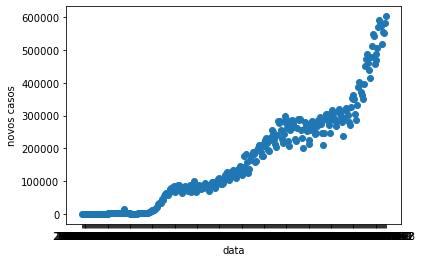

In [3]:
plt.scatter(df['date'], df['new_cases'])
plt.ylabel('novos casos')
plt.xlabel('data')

We can see that as the days were going (not so much in the beginning) the number of new cases grew together.

### Prepare data to use in the model

In [202]:
# Cases will be used as input for the model
cases = df['new_cases'].to_numpy()             

# Build an array of days to use to plot and when the user enter with the number of days ahead to predict
days = []
count = 0
for elements in cases:
  count += 1
  days.append(count)
df['days'] = days
df

,date,new_cases,new_deaths,days
0,2019-12-31,27.0,0.0,1
1,2020-01-01,0.0,0.0,2
2,2020-01-02,0.0,0.0,3
3,2020-01-03,17.0,0.0,4
4,2020-01-04,0.0,0.0,5
...,...,...,...,...
314,2020-11-09,518194.0,6135.0,315
315,2020-11-10,554588.0,8172.0,316
316,2020-11-11,551098.0,9970.0,317
317,2020-11-12,583521.0,10208.0,318


In [203]:
days_after = 9
size = (len(cases) , days_after)
x = np.zeros(size)
y = np.zeros(len(cases))

# The idea is to use a group cases of many days to predict the number of cases of one single day 
for i in range(len(cases) - days_after):
  temp = np.zeros(days_after)
  # Take the days_after's value of elements since i, for cases
  temp[0 : days_after] = cases[i : i+ days_after]
  x[i] = temp
  
  y[i] = cases[i+days_after] # take the number of cases as labels

In [204]:
# Drop the last n days_after of arrays because it only gets 0 
x = x[0:len(df) - days_after]
y = y[0:len(df) - days_after]
# Then drop the value of number days since this values aren't in the x and y anymore
days = days[0:len(df) - days_after]

In [205]:
split = int(0.67*len(x))
days = days[split:]

### Split data, build and train model, and validate

13075.67387929717


array([0.96207261, 0.96698077])

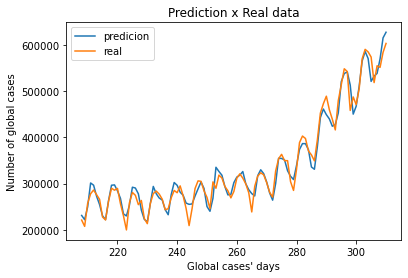

In [206]:
model = Lars(n_nonzero_coefs=1000)
X_train, X_test, y_train, y_test = x[:split], x[split:], y[:split], y[split:]
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
model.fit(X_train, y_train)
print("{}".format(np.linalg.norm(model.predict(X_test) - y_test, 1)/len(y_test)))
predict = model.predict(X_test)
plt.title("Prediction x Real data")
plt.ticklabel_format(style='plain')
plt.plot( days, predict, label = "predicion")
plt.plot( days, y_test,  label = "real")
plt.xlabel("Global cases' days")
plt.ylabel("Number of global cases")
plt.legend()
cross_val_score(model, X_train, y_train, cv = 2)

In [212]:
model.score(X_test, y_test)

0.972320499220924

### Save model

In [208]:
import pickle
# save the model to disk
filename = 'model.sav'
pickle.dump(model, open(filename, 'wb'))
 

# File 2

### Load the model

In [225]:

# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.least_angle module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Lars from version 0.21.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


### Predict the next days number of new cases

In [226]:
from datetime import date
size = (2 , days_after) 
def predict(n_days):
    new_cases = cases
    for i in range(1, n_days+1):
        currentX = np.zeros(size)
        temp = np.zeros(days_after)
        temp[:days_after] = new_cases[-days_after:] # the last n days_after cases
        currentX[0] = temp
        currentX[1] = temp

        prediction = loaded_model.predict(currentX)
        prediction = prediction[0]
        new_cases = np.append(new_cases, prediction)
        print("D "+str(i)+" : " + str(int(prediction)))
        print("Today's date : " + str(date.today()))
    
predict(10)

D 1 : 603380
Today's date : 2020-11-13
D 2 : 582466
Today's date : 2020-11-13
D 3 : 554196
Today's date : 2020-11-13
D 4 : 562674
Today's date : 2020-11-13
D 5 : 589998
Today's date : 2020-11-13
D 6 : 610076
Today's date : 2020-11-13
D 7 : 636350
Today's date : 2020-11-13
D 8 : 633752
Today's date : 2020-11-13
D 9 : 610660
Today's date : 2020-11-13
D 10 : 588210
Today's date : 2020-11-13
